# Face Mask Recognition

## Data Preprocessing and Model Architecture

This includes:

Importing the required libraries
Loading the Data and preprocessing it
Defining the model architecture
Building the training model and necessary helper functions

Hyperparameter tuning is done for each optimiser seperately



### Importing the required Libraries

In [1]:
import os
import cv2
import pathlib
import torch
import torchvision
import glob
import math
import pyttsx3 
import numpy as np 
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader as dl
from torch.utils.data import random_split

### Loading the Dataset and categorising

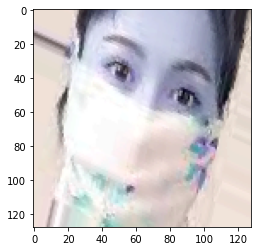

In [2]:
# base directory with images which form the dataset
# can/must be changed when running on other machines
train_data_dir = "/Users/manasaivaturi/Desktop/Masters/Applied ML/Dataset" 

# directory with all test images
# can/must be changed when running on other machines
test_data_dir = "/Users/manasaivaturi/Desktop/Masters/Applied ML" 

# forming the train images dir path
train_data_path = pathlib.Path(train_data_dir)

# forming the test image dir path
test_data_path = pathlib.Path(test_data_dir)

# images for respective images are placed in these respective directories
image_categories = ["with_mask","mask_weared_incorrect","without_mask"]

# looping on existing categories to collect all images and save them as dataset.
for category in image_categories:
    path = os.path.join(train_data_dir,category)
    for img in os.listdir(path):
        temp_img = cv2.imread(os.path.join(path,img))
        plt.imshow(temp_img)
        plt.show()
        break
    break

### Transforming the images

In [3]:
# resizing/rescaling the image to 64*64 alongside normalizing the image
transform = transforms.Compose([transforms.Resize((64, 64)), 
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), 
                                                     (0.5, 0.5, 0.5))])

In [4]:
# reading the data from the training data path
dataset = torchvision.datasets.ImageFolder(train_data_dir, transform = transform)
batch_size = 50

In [5]:
print(len(dataset))

8982


### Splitting the data set to training and validation sets

In [6]:
# as we are having a fewer number of images we are taking a 1000 validation images
val_size = 3000

# training data set is all the remaining images.
trains_size = len(dataset) - val_size

# splitting the original dataset into training and validation datasets
train_dataset, val_dataset = random_split(dataset, [trains_size, val_size])

In [7]:
print(len(train_dataset))
print(len(val_dataset))

5982
3000


### Loading the datasets into dataloaders

In [8]:
train_dl = dl(train_dataset, batch_size, shuffle = False, num_workers = 4)
val_dl = dl(val_dataset, batch_size, shuffle = False, num_workers = 4)

### Setting the loss function

In [9]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

### Defining the model architecture and process

In [10]:
class ImageClassification(nn.Module):

    def train_step(self, batch):
        # images and their respective labels are taken and saved accordingly.
        images, labels = batch
        
        # output of current images and their predictions
        out = self(images)
        
        # calculating the loss - as taken above
        loss = loss_func(out, labels)
        
        # returning loss for further operation
        return loss

    def validation_step(self, batch):
        
        # images and their respective labels are taken and saved accordingly.
        images, labels = batch
        
        # output of current images and their predictions
        out = self(images)

        # calculating the loss - as taken above  
        loss = loss_func(out, labels) 
        
        # accuracy of the validation is calulated         
        acc = accuracy(out, labels)
    
        # returning loss for further operation
        return {'val_loss': loss.detach(), 'val_acc': acc}


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch + 1, result['train_loss'], result['val_loss'], result['val_acc']))


In [11]:
class MaskClassification(ImageClassification):
    def __init__(self):
        super().__init__()
        
        # LAYER 1
        conv_layer1 = nn.Conv2d(3, 32, kernel_size = 3, padding = (2, 2), stride = 2)
        nn.init.xavier_uniform_(conv_layer1.weight)
        self.conv1 = nn.Sequential(         
            conv_layer1,      
            nn.ReLU(), 
        )
        
        conv_layer1_ = nn.Conv2d(32, 64, kernel_size = 3, padding = (2, 2), stride = 2)
        nn.init.xavier_uniform_(conv_layer1_.weight)
        self.conv1_ = nn.Sequential(
            conv_layer1_,
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
        )
       
        # LAYER 2
        conv_layer2 = nn.Conv2d(64, 64, kernel_size = 3, padding = (2, 2), stride = 2)
        nn.init.xavier_uniform_(conv_layer2.weight)
        self.conv2 = nn.Sequential(         
            conv_layer2,    
            nn.ReLU(),
        )
        conv_layer2_ = nn.Conv2d(64, 64, kernel_size = 3, padding = (2, 2), stride = 2)
        nn.init.xavier_uniform_(conv_layer2_.weight)
        self.conv2_ = nn.Sequential(
            conv_layer2_,
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),            
        )  
        
        # LAYER 3
        conv_layer3 = nn.Conv2d(64, 128, kernel_size = 3, padding = (2, 2), stride = 2)
        nn.init.xavier_uniform_(conv_layer3.weight)
        
        self.conv3 = nn.Sequential(         
            conv_layer3,    
            nn.ReLU(),
        )
        
        conv_layer3_ = nn.Conv2d(128, 128, kernel_size = 3, padding = (2, 2), stride = 2)
        nn.init.xavier_uniform_(conv_layer2.weight)
        
        self.conv3_ = nn.Sequential(
            conv_layer3_,
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),            
        )  
        
        # LAST LAYERS
        dnn_layer = nn.Linear(128, 512)
        self.dnn1 = nn.Sequential(  
            dnn_layer,    
            nn.ReLU(),
        )
        self.out = nn.Linear(512, 3)

    def forward(self, x):
        #return self.network(xb)
        x = self.conv1(x)
        x = self.conv1_(x)
        x = self.conv2(x)
        x = self.conv2_(x)
        x = self.conv3(x)
        x = self.conv3_(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)  
        x = self.dnn1(x)
        #x = self.dnn2(x)
        output = self.out(x)
        return output   # return x for visualization

In [12]:
model = MaskClassification()

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func, isSGD = 0):
    saved_data = []
    training_results = []
    if(isSGD == 1):
        optimizer = opt_func(model.parameters(), lr, momentum = 0.9, nesterov = True)
    else:
        optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_acc = []
        step = 0
        max_step = len(train_loader)
        for batch in train_loader:
            loss = model.train_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            step += 1
            if step % 10 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, epochs, step, max_step, loss))
        result = evaluate(model, val_loader)
        result_train = evaluate(model, train_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        print("___",epoch + 1,"___")
        saved_data.append(result)
        training_results.append(result_train) 
        
    return saved_data, training_results

In [13]:
model = MaskClassification()
print(model)

MaskClassification(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (conv1_): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (conv2_): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (conv3_): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kern

## Using SGD Optimiser

### Tuning Parameters

In [14]:
num_of_epoch = 20
optimizer_func = torch.optim.SGD
lr = 0.0055
isSGD = 1

### Training the model

In [15]:
saved_data, training_results = fit(num_of_epoch, lr, model, train_dl, val_dl, optimizer_func, isSGD)

Epoch [1/20], Step [10/120], Loss: 1.0995
Epoch [1/20], Step [20/120], Loss: 1.0999
Epoch [1/20], Step [30/120], Loss: 1.0988
Epoch [1/20], Step [40/120], Loss: 1.0991
Epoch [1/20], Step [50/120], Loss: 1.0973
Epoch [1/20], Step [60/120], Loss: 1.0999
Epoch [1/20], Step [70/120], Loss: 1.1025
Epoch [1/20], Step [80/120], Loss: 1.0980
Epoch [1/20], Step [90/120], Loss: 1.0977
Epoch [1/20], Step [100/120], Loss: 1.0975
Epoch [1/20], Step [110/120], Loss: 1.0967
Epoch [1/20], Step [120/120], Loss: 1.0992
Epoch 1: train_loss: 1.0989, val_loss: 1.0987, val_acc: 0.3243
___ 1 ___
Epoch [2/20], Step [10/120], Loss: 1.0999
Epoch [2/20], Step [20/120], Loss: 1.1012
Epoch [2/20], Step [30/120], Loss: 1.0988
Epoch [2/20], Step [40/120], Loss: 1.0970
Epoch [2/20], Step [50/120], Loss: 1.0960
Epoch [2/20], Step [60/120], Loss: 1.0989
Epoch [2/20], Step [70/120], Loss: 1.1022
Epoch [2/20], Step [80/120], Loss: 1.0982
Epoch [2/20], Step [90/120], Loss: 1.0983
Epoch [2/20], Step [100/120], Loss: 1.0971

In [16]:
print(saved_data)

[{'val_loss': 1.0987299680709839, 'val_acc': 0.3243333101272583, 'train_loss': 1.0988693237304688}, {'val_loss': 1.0982470512390137, 'val_acc': 0.3243333101272583, 'train_loss': 1.0984594821929932}, {'val_loss': 1.0964728593826294, 'val_acc': 0.3266666829586029, 'train_loss': 1.0976420640945435}, {'val_loss': 1.0720247030258179, 'val_acc': 0.5530000329017639, 'train_loss': 1.091073751449585}, {'val_loss': 0.845311164855957, 'val_acc': 0.612000048160553, 'train_loss': 0.9636980295181274}, {'val_loss': 0.7090725302696228, 'val_acc': 0.7056666612625122, 'train_loss': 0.7913913726806641}, {'val_loss': 0.5640944838523865, 'val_acc': 0.7836666107177734, 'train_loss': 0.6689140200614929}, {'val_loss': 0.4253693222999573, 'val_acc': 0.8526666164398193, 'train_loss': 0.5525830388069153}, {'val_loss': 0.3376002311706543, 'val_acc': 0.8783333897590637, 'train_loss': 0.4309634566307068}, {'val_loss': 0.2959202229976654, 'val_acc': 0.8926666378974915, 'train_loss': 0.36186257004737854}, {'val_loss'

In [17]:
print(training_results)

[{'val_loss': 1.0982352495193481, 'val_acc': 0.33786454796791077}, {'val_loss': 1.0977463722229004, 'val_acc': 0.33786454796791077}, {'val_loss': 1.095909595489502, 'val_acc': 0.34045833349227905}, {'val_loss': 1.0711921453475952, 'val_acc': 0.5661875605583191}, {'val_loss': 0.8413472771644592, 'val_acc': 0.6363020539283752}, {'val_loss': 0.7075292468070984, 'val_acc': 0.7187291383743286}, {'val_loss': 0.5605396032333374, 'val_acc': 0.7910832762718201}, {'val_loss': 0.4162808060646057, 'val_acc': 0.8620312809944153}, {'val_loss': 0.326962411403656, 'val_acc': 0.885270893573761}, {'val_loss': 0.27844876050949097, 'val_acc': 0.9049583077430725}, {'val_loss': 0.2436860054731369, 'val_acc': 0.9187187552452087}, {'val_loss': 0.2204236537218094, 'val_acc': 0.9233124852180481}, {'val_loss': 0.19583456218242645, 'val_acc': 0.9344791769981384}, {'val_loss': 0.17841285467147827, 'val_acc': 0.9382396340370178}, {'val_loss': 0.1600617915391922, 'val_acc': 0.9465729594230652}, {'val_loss': 0.139581

### Results of training using SGD Optimiser

In [18]:
print("SGD Optimiser Results:\n")
loss = [_["train_loss"] for _ in saved_data]
valid_loss = [_["val_loss"] for _ in saved_data]
val_acc = [_["val_acc"] for _ in saved_data]
train_acc = [_["val_acc"] for _ in training_results]
avg_val_accuracy = (sum(val_acc)*100) / 20
print("Average accuracy obtained on Validation Data: %.3f" %avg_val_accuracy)
max_val_accuracy = max(val_acc)*100
print("Maximum accuracy obtained on Validation Data: %.3f\n" % max_val_accuracy)

SGD Optimiser Results:

Average accuracy obtained on Validation Data: 78.182
Maximum accuracy obtained on Validation Data: 95.600



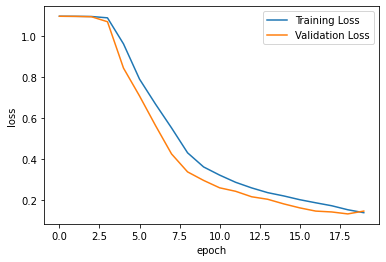

In [19]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.arange(0,num_of_epoch),np.array(loss), label = "Training Loss")
plt.plot(np.arange(0,num_of_epoch),np.array(valid_loss), label = "Validation Loss")
plt.legend(loc = "upper right")

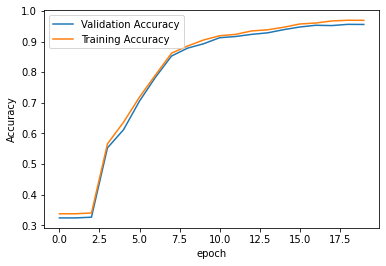

In [20]:
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.plot(np.arange(0,num_of_epoch),np.array(val_acc), label = "Validation Accuracy")
plt.plot(np.arange(0,num_of_epoch),np.array(train_acc), label = "Training Accuracy")
plt.legend(loc = "upper left")

In [21]:
root = pathlib.Path(train_data_dir)
classes = sorted([_.name.split('\\')[-1] for _ in root.iterdir()])
try:
    classes.remove(".DS_Store") #For Mac devices
except:
    pass

In [22]:
print(classes)

['mask_weared_incorrect', 'with_mask', 'without_mask']


In [23]:
#Transforms
transformer = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5, 0.5, 0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5, 0.5, 0.5])
])

### Predicting on unseen images

In [24]:
# Prediction Function

def prediction(img_path,transformer):
    image = Image.open(img_path)
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    # plt.imshow(  image_tensor )
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input = Variable(image_tensor)
    output = model(input)
    print(output)
    index = output.data.numpy().argmax()
    pred = classes[index]
    return pred

In [25]:
# text to speech
engine = pyttsx3.init()

In [26]:
# How to predict
prediction_root = os.path.join(test_data_path, "for_prediction")
CATEGORIES = [ "frame1.jpg","frame2.jpg", "frame3.png"]
results = []
print("With SGD Optimiser")
for category in CATEGORIES:
    print(category)
    image_path = os.path.join(prediction_root, category)
    results.append( prediction(image_path,transformer))

results

With SGD Optimiser
frame1.jpg
tensor([[ 1.1457,  0.6365, -1.7408]], grad_fn=<AddmmBackward0>)
frame2.jpg
tensor([[ 2.0857, -0.1981, -1.8633]], grad_fn=<AddmmBackward0>)
frame3.png
tensor([[-4.3484,  0.6193,  3.5155]], grad_fn=<AddmmBackward0>)


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


['mask_weared_incorrect', 'mask_weared_incorrect', 'without_mask']

In [27]:
### Text to Speech usage:

In [28]:
for _ in results:
    if _ == 'with_mask':
        engine.runAndWait()
    elif _ =='mask_weared_incorrect':
        engine.say("Please wear mask properly")
        engine.runAndWait() 
    else :
        engine.say("Please wear a mask")
        engine.runAndWait() 

In [29]:
# Save the model
FILE = "model_SGD.pth"
torch.save(model.state_dict(), FILE)

## Using Adam Optimiser

### Tuning Parameters

In [30]:
num_of_epoch = 15
optimizer_func = torch.optim.Adam
lr = 0.0001
model = MaskClassification()

### Training the model

In [31]:
saved_data, training_results = fit(num_of_epoch, lr, model, train_dl, val_dl, optimizer_func)

Epoch [1/15], Step [10/120], Loss: 1.0927
Epoch [1/15], Step [20/120], Loss: 1.1056
Epoch [1/15], Step [30/120], Loss: 1.0951
Epoch [1/15], Step [40/120], Loss: 1.0894
Epoch [1/15], Step [50/120], Loss: 1.0855
Epoch [1/15], Step [60/120], Loss: 1.0729
Epoch [1/15], Step [70/120], Loss: 1.0225
Epoch [1/15], Step [80/120], Loss: 0.9959
Epoch [1/15], Step [90/120], Loss: 0.9433
Epoch [1/15], Step [100/120], Loss: 0.8822
Epoch [1/15], Step [110/120], Loss: 0.7742
Epoch [1/15], Step [120/120], Loss: 0.7793
Epoch 1: train_loss: 1.0051, val_loss: 0.7564, val_acc: 0.6603
___ 1 ___
Epoch [2/15], Step [10/120], Loss: 0.8133
Epoch [2/15], Step [20/120], Loss: 0.8031
Epoch [2/15], Step [30/120], Loss: 0.6186
Epoch [2/15], Step [40/120], Loss: 0.5722
Epoch [2/15], Step [50/120], Loss: 0.7580
Epoch [2/15], Step [60/120], Loss: 0.7055
Epoch [2/15], Step [70/120], Loss: 0.6391
Epoch [2/15], Step [80/120], Loss: 0.6551
Epoch [2/15], Step [90/120], Loss: 0.7863
Epoch [2/15], Step [100/120], Loss: 0.7757

In [32]:
print(saved_data)

[{'val_loss': 0.7564188838005066, 'val_acc': 0.6603333353996277, 'train_loss': 1.0051302909851074}, {'val_loss': 0.5503721237182617, 'val_acc': 0.7576667070388794, 'train_loss': 0.6839542984962463}, {'val_loss': 0.4520554542541504, 'val_acc': 0.8179999589920044, 'train_loss': 0.5548868775367737}, {'val_loss': 0.39407703280448914, 'val_acc': 0.8493333458900452, 'train_loss': 0.47853437066078186}, {'val_loss': 0.34964483976364136, 'val_acc': 0.8663333654403687, 'train_loss': 0.4184481203556061}, {'val_loss': 0.3064515292644501, 'val_acc': 0.887999951839447, 'train_loss': 0.3747034966945648}, {'val_loss': 0.2732720375061035, 'val_acc': 0.9029999375343323, 'train_loss': 0.34504109621047974}, {'val_loss': 0.25194135308265686, 'val_acc': 0.9099999070167542, 'train_loss': 0.3174556791782379}, {'val_loss': 0.2269248217344284, 'val_acc': 0.9230000376701355, 'train_loss': 0.2932196855545044}, {'val_loss': 0.2101806253194809, 'val_acc': 0.9300001263618469, 'train_loss': 0.25656965374946594}, {'va

In [33]:
print(training_results)

[{'val_loss': 0.7492859959602356, 'val_acc': 0.6806562542915344}, {'val_loss': 0.5539225339889526, 'val_acc': 0.7651978731155396}, {'val_loss': 0.4591030478477478, 'val_acc': 0.8119166493415833}, {'val_loss': 0.3996255695819855, 'val_acc': 0.840343713760376}, {'val_loss': 0.3508433997631073, 'val_acc': 0.8615103363990784}, {'val_loss': 0.30571305751800537, 'val_acc': 0.881937563419342}, {'val_loss': 0.270363450050354, 'val_acc': 0.900791585445404}, {'val_loss': 0.24725976586341858, 'val_acc': 0.9116249680519104}, {'val_loss': 0.2226984053850174, 'val_acc': 0.9236457943916321}, {'val_loss': 0.2039104402065277, 'val_acc': 0.9314791560173035}, {'val_loss': 0.18309859931468964, 'val_acc': 0.9371458292007446}, {'val_loss': 0.18102551996707916, 'val_acc': 0.9381458163261414}, {'val_loss': 0.1716669350862503, 'val_acc': 0.9426459074020386}, {'val_loss': 0.1428050994873047, 'val_acc': 0.953499972820282}, {'val_loss': 0.13468165695667267, 'val_acc': 0.954572856426239}]


### Results of training using Adam Optimiser

In [34]:
print("Adam Optimiser Results:\n")
loss = [_["train_loss"] for _ in saved_data]
valid_loss = [_["val_loss"] for _ in saved_data]
val_acc = [_["val_acc"] for _ in saved_data]
train_acc = [_["val_acc"] for _ in training_results]
avg_val_accuracy = (sum(val_acc)*100) / 15
print("Average accuracy obtained on Validation Data: %.3f" %avg_val_accuracy)
max_val_accuracy = max(val_acc)*100
print("Maximum accuracy obtained on Validation Data: %.3f\n" % max_val_accuracy)

Adam Optimiser Results:

Average accuracy obtained on Validation Data: 88.062
Maximum accuracy obtained on Validation Data: 95.100



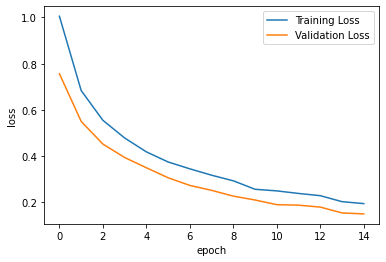

In [35]:
plt.xlabel("epoch")
plt.ylabel("loss")
num_of_epoch = 15
plt.plot(np.arange(0,num_of_epoch),np.array(loss), label = "Training Loss")
plt.plot(np.arange(0,num_of_epoch),np.array(valid_loss), label = "Validation Loss")
plt.legend(loc = "upper right")

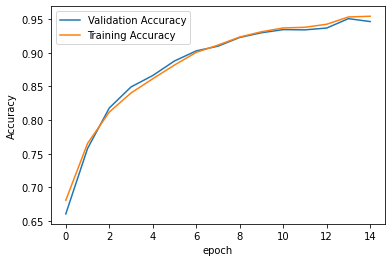

In [36]:
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.plot(np.arange(0,num_of_epoch),np.array(val_acc), label = "Validation Accuracy")
plt.plot(np.arange(0,num_of_epoch),np.array(train_acc), label = "Training Accuracy")
plt.legend(loc = "upper left")

In [37]:
root = pathlib.Path(train_data_dir)
classes = sorted([_.name.split('\\')[-1] for _ in root.iterdir()])
try:
    classes.remove(".DS_Store") #For Mac devices
except:
    pass

In [38]:
print(classes)

['mask_weared_incorrect', 'with_mask', 'without_mask']


In [39]:
#Transforms
transformer = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5, 0.5, 0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5, 0.5, 0.5])
])

### Predicting on unseen images

In [40]:
# Prediction Function

def prediction(img_path,transformer):
    image = Image.open(img_path)
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    # plt.imshow(  image_tensor )
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input = Variable(image_tensor)
    output = model(input)
    print(output)
    index = output.data.numpy().argmax()
    pred = classes[index]
    return pred

In [41]:
# text to speech
engine = pyttsx3.init()

In [42]:
# How to predict
prediction_root = os.path.join(test_data_path, "for_prediction")
CATEGORIES = [ "frame1.jpg","frame2.jpg", "frame3.png"]
results = []
print("With Adam Optimiser")
for category in CATEGORIES:
    print(category)
    image_path = os.path.join(prediction_root, category)
    results.append( prediction(image_path,transformer))

results

With Adam Optimiser
frame1.jpg
tensor([[-1.6401,  2.4220, -2.2438]], grad_fn=<AddmmBackward0>)
frame2.jpg
tensor([[ 2.0380, -0.0619, -3.4109]], grad_fn=<AddmmBackward0>)
frame3.png
tensor([[-3.0496,  0.7615,  0.8161]], grad_fn=<AddmmBackward0>)


['with_mask', 'mask_weared_incorrect', 'without_mask']

In [43]:
for _ in results:
    if _ == 'with_mask':
        engine.runAndWait()
    elif _ =='mask_weared_incorrect':
        engine.say("Please wear mask properly")
        engine.runAndWait() 
    else :
        engine.say("Please wear a mask")
        engine.runAndWait() 

In [44]:
# Save the model
FILE = "model_Adam.pth"
torch.save(model.state_dict(), FILE)

## Using RMSprop optimizer 

### Tuning Parameters

In [45]:
num_of_epoch = 15
optimizer_func = torch.optim.RMSprop
lr = 0.0001
model = MaskClassification()

### Training the model

In [46]:
saved_data, training_results = fit(num_of_epoch, lr, model, train_dl, val_dl, optimizer_func)

Epoch [1/15], Step [10/120], Loss: 1.0815
Epoch [1/15], Step [20/120], Loss: 0.9892
Epoch [1/15], Step [30/120], Loss: 0.8079
Epoch [1/15], Step [40/120], Loss: 0.6336
Epoch [1/15], Step [50/120], Loss: 0.9249
Epoch [1/15], Step [60/120], Loss: 0.8665
Epoch [1/15], Step [70/120], Loss: 0.8796
Epoch [1/15], Step [80/120], Loss: 0.7860
Epoch [1/15], Step [90/120], Loss: 0.7677
Epoch [1/15], Step [100/120], Loss: 0.8583
Epoch [1/15], Step [110/120], Loss: 0.7889
Epoch [1/15], Step [120/120], Loss: 0.7422
Epoch 1: train_loss: 0.8453, val_loss: 0.6874, val_acc: 0.6923
___ 1 ___
Epoch [2/15], Step [10/120], Loss: 0.7484
Epoch [2/15], Step [20/120], Loss: 0.7267
Epoch [2/15], Step [30/120], Loss: 0.6176
Epoch [2/15], Step [40/120], Loss: 0.5002
Epoch [2/15], Step [50/120], Loss: 0.7315
Epoch [2/15], Step [60/120], Loss: 0.7108
Epoch [2/15], Step [70/120], Loss: 0.6557
Epoch [2/15], Step [80/120], Loss: 0.5491
Epoch [2/15], Step [90/120], Loss: 0.7423
Epoch [2/15], Step [100/120], Loss: 0.7150

In [47]:
print(saved_data)

[{'val_loss': 0.6874212026596069, 'val_acc': 0.6923333406448364, 'train_loss': 0.845346987247467}, {'val_loss': 0.5246540904045105, 'val_acc': 0.7849999666213989, 'train_loss': 0.6455908417701721}, {'val_loss': 0.4418376386165619, 'val_acc': 0.8256666660308838, 'train_loss': 0.5399920344352722}, {'val_loss': 0.4108530282974243, 'val_acc': 0.8446667194366455, 'train_loss': 0.4721042215824127}, {'val_loss': 0.3534257113933563, 'val_acc': 0.8673332333564758, 'train_loss': 0.43023431301116943}, {'val_loss': 0.32869651913642883, 'val_acc': 0.8796666860580444, 'train_loss': 0.3914608359336853}, {'val_loss': 0.29052966833114624, 'val_acc': 0.8943333029747009, 'train_loss': 0.36149442195892334}, {'val_loss': 0.2701616883277893, 'val_acc': 0.902999997138977, 'train_loss': 0.3370125889778137}, {'val_loss': 0.257956326007843, 'val_acc': 0.9046667218208313, 'train_loss': 0.312678724527359}, {'val_loss': 0.24205802381038666, 'val_acc': 0.9143333435058594, 'train_loss': 0.29105597734451294}, {'val_l

In [48]:
print(training_results)

[{'val_loss': 0.6964101791381836, 'val_acc': 0.6889374852180481}, {'val_loss': 0.5397669672966003, 'val_acc': 0.7789375185966492}, {'val_loss': 0.4553181529045105, 'val_acc': 0.8170104622840881}, {'val_loss': 0.42011138796806335, 'val_acc': 0.8356771469116211}, {'val_loss': 0.3570444881916046, 'val_acc': 0.8638437986373901}, {'val_loss': 0.3308262526988983, 'val_acc': 0.8728438019752502}, {'val_loss': 0.2861778140068054, 'val_acc': 0.8965312242507935}, {'val_loss': 0.26267069578170776, 'val_acc': 0.906791627407074}, {'val_loss': 0.25017479062080383, 'val_acc': 0.9100521206855774}, {'val_loss': 0.2338716983795166, 'val_acc': 0.9153854250907898}, {'val_loss': 0.2060082107782364, 'val_acc': 0.9292187094688416}, {'val_loss': 0.19101203978061676, 'val_acc': 0.9317187070846558}, {'val_loss': 0.20632311701774597, 'val_acc': 0.9233124852180481}, {'val_loss': 0.16613741219043732, 'val_acc': 0.9409791827201843}, {'val_loss': 0.16020020842552185, 'val_acc': 0.9428126215934753}]


### Results of training using RMSprop Optimiser

In [49]:
print("RMSprop Optimiser Results:\n")
loss = [_["train_loss"] for _ in saved_data]
valid_loss = [_["val_loss"] for _ in saved_data]
val_acc = [_["val_acc"] for _ in saved_data]
train_acc = [_["val_acc"] for _ in training_results]
avg_val_accuracy = (sum(val_acc)*100) / 15
print("Average accuracy obtained on Validation Data: %.3f" %avg_val_accuracy)
max_val_accuracy = max(val_acc)*100
print("Maximum accuracy obtained on Validation Data: %.3f\n" % max_val_accuracy)

RMSprop Optimiser Results:

Average accuracy obtained on Validation Data: 87.851
Maximum accuracy obtained on Validation Data: 94.400



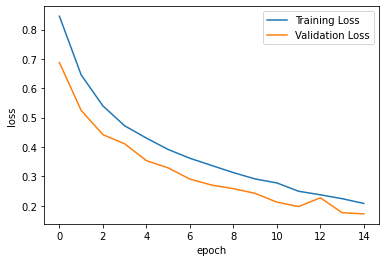

In [50]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.arange(0,num_of_epoch),np.array(loss), label = "Training Loss")
plt.plot(np.arange(0,num_of_epoch),np.array(valid_loss), label = "Validation Loss")
plt.legend(loc = "upper right")

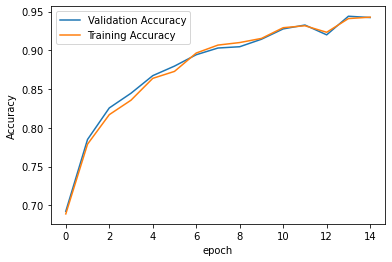

In [51]:
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.plot(np.arange(0,num_of_epoch),np.array(val_acc), label = "Validation Accuracy")
plt.plot(np.arange(0,num_of_epoch),np.array(train_acc), label = "Training Accuracy")
plt.legend(loc="upper left")

In [52]:
root = pathlib.Path(train_data_dir)
classes = sorted([_.name.split('\\')[-1] for _ in root.iterdir()])
try:
    classes.remove(".DS_Store") #For Mac devices
except:
    pass

In [53]:
print(classes)

['mask_weared_incorrect', 'with_mask', 'without_mask']


In [54]:
#Transforms
transformer = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5, 0.5, 0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5, 0.5, 0.5])
])

### Predicting on unseen images

In [55]:
# Prediction Function

def prediction(img_path,transformer):
    image = Image.open(img_path)
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    # plt.imshow(  image_tensor )
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input = Variable(image_tensor)
    output = model(input)
    print(output)
    index = output.data.numpy().argmax()
    pred = classes[index]
    return pred

In [56]:
# text to speech
engine = pyttsx3.init()

In [57]:
# How to predict
prediction_root = os.path.join(test_data_path, "for_prediction")
CATEGORIES = [ "frame1.jpg", "frame2.jpg", "frame3.png"]
results = []
print("With RMSprop Optimiser")
for category in CATEGORIES:
    print(category)
    image_path = os.path.join(prediction_root, category)
    results.append( prediction(image_path,transformer))

results

With RMSprop Optimiser
frame1.jpg
tensor([[-1.7556,  1.7792, -0.6254]], grad_fn=<AddmmBackward0>)
frame2.jpg
tensor([[ 0.7265,  0.2429, -1.9444]], grad_fn=<AddmmBackward0>)
frame3.png
tensor([[-2.1267, -0.0793,  1.8564]], grad_fn=<AddmmBackward0>)


['with_mask', 'mask_weared_incorrect', 'without_mask']

In [58]:
for _ in results:
    if _ == 'with_mask':
        engine.runAndWait()
    elif _ =='mask_weared_incorrect':
        engine.say("Please wear mask properly")
        engine.runAndWait() 
    else :
        engine.say("Please wear a mask")
        engine.runAndWait() 

In [59]:
# Save the model
FILE = "model_RMSprop.pth"
torch.save(model.state_dict(), FILE)

## Testing on a video file

### Reading the video using cv2 and capturing frames from the video

In [14]:
#using video to make prediction

prediction_root_vid = os.path.join(test_data_path, "for_prediction/vid.mp4")
vid = cv2.VideoCapture(prediction_root_vid)
currentframe = 0

try:
    if not os.path.exists('video_images'):
        os.makedirs('video_images')

    while(True):
        success,frame = vid.read()
        if frame is None:
            break
        cv2.imshow("Output",frame)
        cv2.imwrite('./video_images/frame'+ str(currentframe)+ '.jpg',frame)
        currentframe += 1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    print("Total Frames: ", currentframe)
    cv2.destroyAllWindows() 
except Exception as e:
    print(e)
    pass


Total Frames:  702


### Prediction Function

In [15]:
def prediction(img_path,transformer):
    image = Image.open(img_path)
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    # plt.imshow(  image_tensor )
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input = Variable(image_tensor)
    output = model(input)
    print(output)
    index = output.data.numpy().argmax()
    pred = classes[index]
    return pred

In [16]:
root = pathlib.Path(train_data_dir)
classes = sorted([_.name.split('\\')[-1] for _ in root.iterdir()])
classes.remove(".DS_Store")

In [17]:
print(classes)

['mask_weared_incorrect', 'with_mask', 'without_mask']


In [18]:
#Transforms
transformer = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5, 0.5, 0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5, 0.5, 0.5])
])

### Loading the saved Model

In [23]:
FILE = "model_RMSprop.pth"
model = MaskClassification()
model.load_state_dict(torch.load(FILE))

<All keys matched successfully>

### Testing on the images from the video

tensor([[-3.0305,  2.2201,  0.8678]], grad_fn=<AddmmBackward0>)


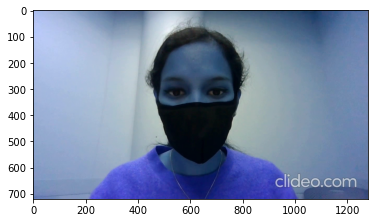

with_mask


In [24]:
image1 = "./video_images/frame389.jpg"
result = prediction(image1,transformer)
image1 = cv2.imread(os.path.join(image1))
plt.imshow(image1)
plt.show()

print(result)

tensor([[-4.6334,  1.4953,  2.8419]], grad_fn=<AddmmBackward0>)


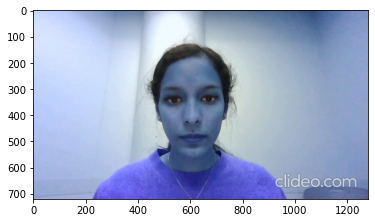

without_mask


In [25]:
image1 = "./video_images/frame650.jpg"
result = prediction(image1,transformer)
image1 = cv2.imread(os.path.join(image1))
plt.imshow(image1)
plt.show()

print(result)

tensor([[ 1.8722,  0.3246, -2.0914]], grad_fn=<AddmmBackward0>)


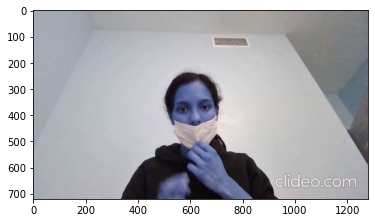

mask_weared_incorrect


In [26]:
image1 = "./video_images/frame221.jpg"
result = prediction(image1,transformer)
image1 = cv2.imread(os.path.join(image1))
plt.imshow(image1)
plt.show()

print(result)

We made use of the following dataset: https://www.kaggle.com/datasets/vijaykumar1799/face-mask-detection